# Forward modelling using simPEG
## Imports and generic functions

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.colors as mcolors
from matplotlib.axes._axes import Axes
import math
import random as rd
from time import perf_counter

# pyGIMLi functionality
import pygimli as pg
import pygimli.physics.ert as ert

# SimPEG functionality
from simpeg.electromagnetics.static import resistivity as dc
from simpeg import maps
from simpeg.electromagnetics.static.utils.static_utils import (
    pseudo_locations,
    plot_pseudosection,
)

# discretize functionality
from discretize import TensorMesh
from discretize.utils import active_from_xyz

# Common Python functionality
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Functions to pass from log normalized resistivity space to physical space.

In [57]:
def detransform(log_res: float | np.ndarray[float]) -> float | np.ndarray[float]:
    return 2 * 10 ** (4 * log_res)
def transform(res: float | np.ndarray[float]) -> float | np.ndarray[float]:
    return np.log10(res / 2) / 4
def deriv_detransform(log_res: float | np.ndarray[float]) -> float | np.ndarray[float]:
    return np.log(10) * 8 * 10 ** (4 * log_res)

Plotting functions

In [58]:
def create_colorbar(sample: np.ndarray[np.int8]) -> tuple[dict[np.int8, tuple[float, float, float, float]], mcolors.BoundaryNorm, mcolors.ListedColormap]:
    classes: np.ndarray[np.int8] = np.unique(sample)
    cmap: mcolors.ListedColormap = plt.get_cmap("tab20", len(classes))
    colors: list[tuple[float, float, float, float]] = [cmap(class_index) for class_index in range(len(classes))]
    class_color_map: dict[np.int8, tuple[float, float, float, float]] = dict(zip(classes, colors))
    norm: mcolors.BoundaryNorm = mcolors.BoundaryNorm(boundaries=np.append(classes - 0.5, classes[-1] + 0.5), ncolors=len(classes))
    cmap = mcolors.ListedColormap(colors)
    return class_color_map, norm, cmap

In [59]:
def sub_plot(axes: np.ndarray[Axes] | Axes,
             idx: int,
             img: np.ndarray[np.int8],
             title: str,
             class_color_map: dict[np.int8, tuple[float, float, float, float]],
             cmap_custom: mcolors.ListedColormap,
             norm: mcolors.BoundaryNorm
             ) -> None:
    if type(axes) is Axes:
        axes = np.array([axes], dtype=Axes)
    axes[idx].imshow(img, cmap=cmap_custom, norm=norm)
    legend_patches = [plt.Line2D([idx], [idx], marker='s', color='w', markerfacecolor=color, markersize=10, label=str(cls)) for cls, color in class_color_map.items()]
    axes[idx].legend(handles=legend_patches, title="Rock Labels", bbox_to_anchor=(0, 1), loc='upper left')
    axes[idx].set_title(title)
    axes[idx].set_ylabel("depth (pixels)")
    axes[idx].set_xlabel("horizontal direction (pixels)")

Function to compute pseudo-section for Wenner array

In [60]:
def compute_active_columns(row: int, is_even_row: bool, total_cols: int, offset: int) -> tuple[int, int]:
    """
    Compute the starting and ending column indices for the given row.
    """
    if is_even_row:
        col_start = math.ceil(row * 1.5) - offset
        col_end = total_cols - math.ceil(row * 1.5) + offset
    else:
        col_start = math.ceil((row + 1) * 1.5) - 1 - offset
        col_end = total_cols - math.ceil((row + 1) * 1.5) + 1 + offset
    return col_start, col_end

## Data paths

In [61]:
dataset_path: Path = Path("../../../clean_reduced_unified")
output_path: Path = Path("../../../dataset/processed")

Get the number or npz archive.

In [62]:
nbr_npz: int = len(list(dataset_path.glob("*.npz")))
print(f"{nbr_npz} files found")

61 files found


## Select a random 2D array

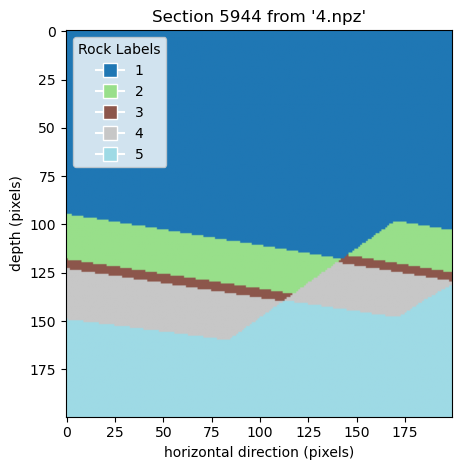

In [63]:
# Choose a random file
npz_idx: int = rd.randint(0, nbr_npz)
# Load the numpy array
multi_array: np.ndarray[np.int8] = np.load(dataset_path / f"{npz_idx}.npz", mmap_mode='r')["arr_0"]
# Choose a random section in this array
section_idx: int = rd.choice(range(len(multi_array)))
# Extract the section
section: np.ndarray[np.int8] = multi_array[section_idx]

# Plot the section
fig, ax = plt.subplots(1, 1)
class_color_map, norm, cmap_custom = create_colorbar(section)
sub_plot(ax, 0, section, f"Section {section_idx} from '{npz_idx}.npz'", class_color_map, cmap_custom, norm)
plt.tight_layout()
plt.show()

## Select a random number of electrode, a random total length to keep and a random interelectrode pixel number

In [64]:
# Choose a random number of electrodes 24 <= n <= 96
num_electrodes: int = rd.randint(24, 97)
# Choose a random length of the subsection to keep num_electrodes - 1 <= n <= horizontal section length
total_pixels_to_keep: int = rd.randint(num_electrodes - 1, section.shape[1])
# Choose a random number of pixel between each electrodes 1 <= 10
inter_electrode_num_pixels: int = rd.randint(1, 4)
# This is the final horizontal section length we want
total_pixels_after_refinement: int = (num_electrodes - 1) * inter_electrode_num_pixels

print(f"Number of electrodes: {num_electrodes}")
print(f"Total pixels to keep: {total_pixels_to_keep}")
print(f"Number of pixels between each electrodes: {inter_electrode_num_pixels}")
print(f"Total pixels after refinement: {total_pixels_after_refinement}")

Number of electrodes: 60
Total pixels to keep: 195
Number of pixels between each electrodes: 3
Total pixels after refinement: 177


We need to reshape horizontally the grid. The reshaping is done using nearest neighbour, this ensures no new rock class is created.

In [65]:
def resize(sample: np.ndarray[np.int8],
           new_shape: tuple[int, int]
           ) -> np.ndarray[np.int8]:
    src_rows, src_cols = sample.shape
    dst_rows, dst_cols = new_shape

    # Compute nearest neighbor indices
    row_indices = np.round(np.linspace(0, src_rows - 1, dst_rows)).astype(int)
    col_indices = np.round(np.linspace(0, src_cols - 1, dst_cols)).astype(int)

    # Use advanced indexing to select nearest neighbors
    resized_array = sample[row_indices[:, None], col_indices]

    return resized_array

def create_random_slice(max_length: int,
                        fraction: float
                        ) -> slice:
    start: int = rd.randint(0, int(max_length * (1 - fraction)))
    return slice(start, start + int(max_length * fraction))

def extract_random_subsection(section: np.ndarray[np.int8],
                              total_pixels_to_keep: int,
                              vertical_fraction: float = 1.,
                              ) -> np.ndarray[np.int8]:
    # Vertical part
    depth_slice: slice = create_random_slice(section.shape[0], vertical_fraction)

    # Horizontal part
    horizontal_fraction: float = total_pixels_to_keep / section.shape[1]
    width_slice: slice = create_random_slice(section.shape[1], horizontal_fraction)

    return section[depth_slice, width_slice], depth_slice, width_slice

Depth slice: slice(78, 178, None)
Width slice: slice(2, 197, None)


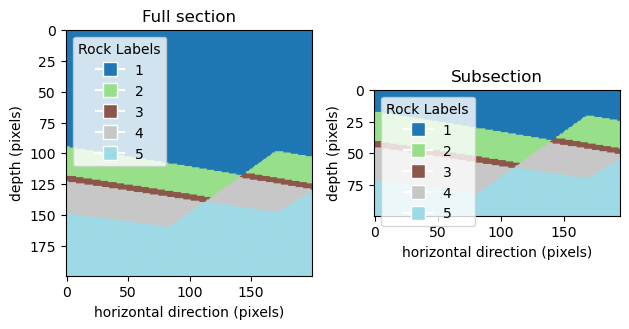

In [66]:
# What fraction of the initial section we want to keep
vertical_fraction: float = 0.5
# Extract the subsection
sub_section, depth_slice, width_slice = extract_random_subsection(section, total_pixels_to_keep, vertical_fraction)
print(f"Depth slice: {depth_slice}")
print(f"Width slice: {width_slice}")

# Plot the section and the subsection
fig, ax = plt.subplots(1, 2)
class_color_map, norm, cmap_custom = create_colorbar(section)
titles: list[str] = [f"Full section", f"Subsection"]
for idx, (img, title) in enumerate(zip([section, sub_section], titles)):
    sub_plot(ax, idx, img, title, class_color_map, cmap_custom, norm)
plt.tight_layout()
plt.show()

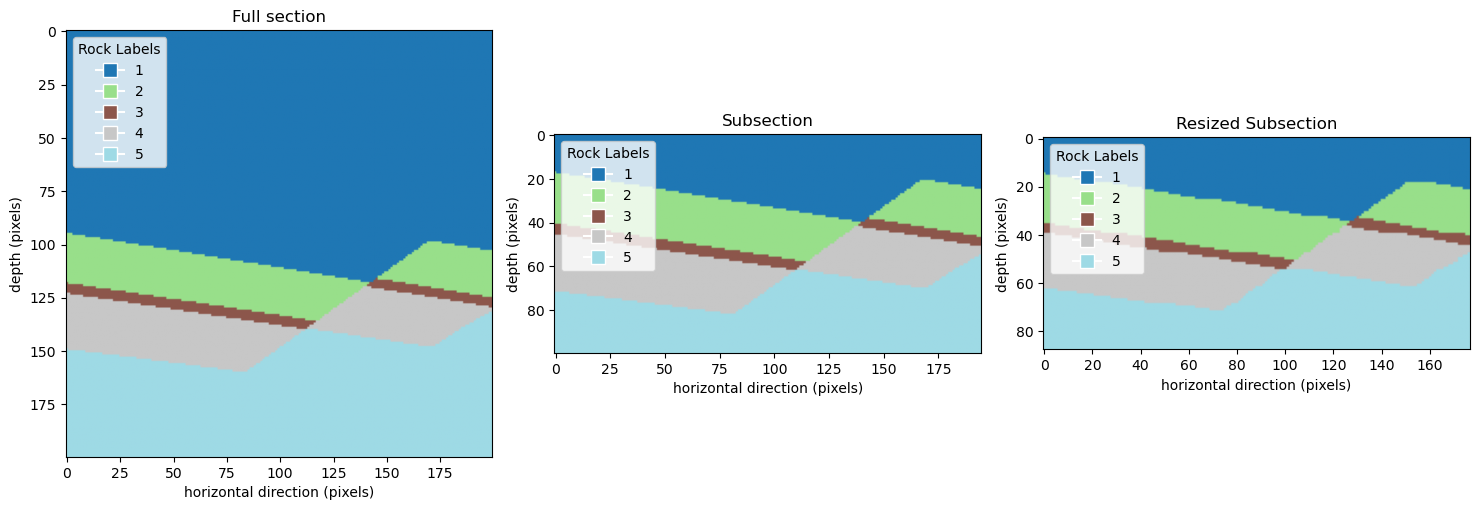

In [67]:
vertical_size: int = int(vertical_fraction * total_pixels_after_refinement)
# Resize the section
sub_section_resized: np.ndarray[np.int8] = resize(sub_section, (vertical_size, total_pixels_after_refinement))

# Plot the section, the subsection and the resized subsection
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
class_color_map, norm, cmap_custom = create_colorbar(section)
titles: list[str] = [f"Full section", f"Subsection", f"Resized Subsection"]
for idx, (img, title) in enumerate(zip([section, sub_section, sub_section_resized], titles)):
    sub_plot(axes, idx, img, title, class_color_map, cmap_custom, norm)
plt.tight_layout()
plt.show()

## Resistivity assignation
We assign each rock class a random resistivity. The resistivity value is sampled from a uniform distribution on $ \left[0, 1\right] $ and mapped using a logarithm function to $ \left[2, 20000\right] $.

In [68]:
# Extract the rock classes
rock_classes, inv = np.unique(sub_section_resized, return_inverse=True)
# Create a random normalized log resistivity value for each rock class
norm_log_res_values: np.ndarray[np.float64] = np.random.uniform(0, 1, size=len(rock_classes))
# Assign the random log resistivity value to each pixel according to its rock class
norm_log_resistivity_model: np.ndarray[np.float64] = norm_log_res_values[inv].reshape(sub_section_resized.shape)
# Detransform the resistivity values
resistivity_model: np.ndarray[np.float64] = detransform(norm_log_resistivity_model)

Rock class 1 with normalized log resistivity 0.7072646406457413 and resistivity 1349.2379815712272 ohm.m
Rock class 2 with normalized log resistivity 0.820314141205241 and resistivity 3821.9637225329393 ohm.m
Rock class 3 with normalized log resistivity 0.9766472649065339 and resistivity 16129.431307993309 ohm.m
Rock class 4 with normalized log resistivity 0.41130388242952876 and resistivity 88.35792846819798 ohm.m
Rock class 5 with normalized log resistivity 0.8995236560680951 and resistivity 7927.287697884651 ohm.m


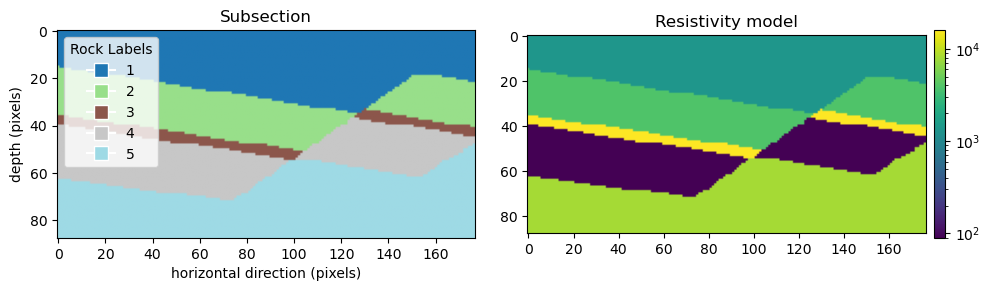

In [69]:
# Print the normalized log resistivity and the resistivity values
for rock_class, norm_log_res in zip(rock_classes, norm_log_res_values):
    print(f"Rock class {rock_class} with normalized log resistivity {norm_log_res} and resistivity {detransform(norm_log_res)} ohm.m")

# Plot the resized subsection and the resistivity model
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sub_plot(axes, 0, sub_section_resized, f"Subsection", class_color_map, cmap_custom, norm)
img = axes[1].imshow(resistivity_model, cmap="viridis", norm=mcolors.LogNorm())
axes[1].set_title(f"Resistivity model")
fig.colorbar(img, ax=axes[1], orientation='vertical', fraction=0.025, pad=0.02)
plt.tight_layout()
plt.show()

## SimPEG process

In SimPEG, boundary conditions are 'Robin' (linear combination of the values of a function and the values of its derivative on the boundary of the domain). We need a air layer with high resistivity to ensure a well-posed problem.

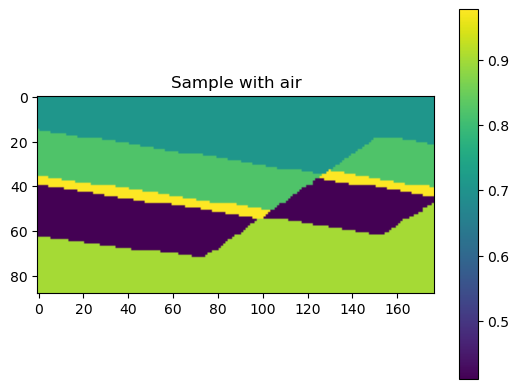

In [70]:
air_layer_thickness = 0

resistivity_model_with_air = np.ones((resistivity_model.shape[0] + air_layer_thickness, resistivity_model.shape[1])) * 1e8
resistivity_model_with_air[air_layer_thickness:, :] = resistivity_model
plt.imshow(transform(resistivity_model_with_air), cmap="viridis")
plt.colorbar()
plt.title("Sample with air")
plt.show()

We will need to flatten arrays to map resistivity model to mesh. Additionnally, the axis of the mesh are flipped compared to the resistivity model.

In [71]:
resistivity_model_flat = np.flipud(resistivity_model).ravel()
norm_log_resistivity_model_flat = np.flipud(norm_log_resistivity_model).ravel()

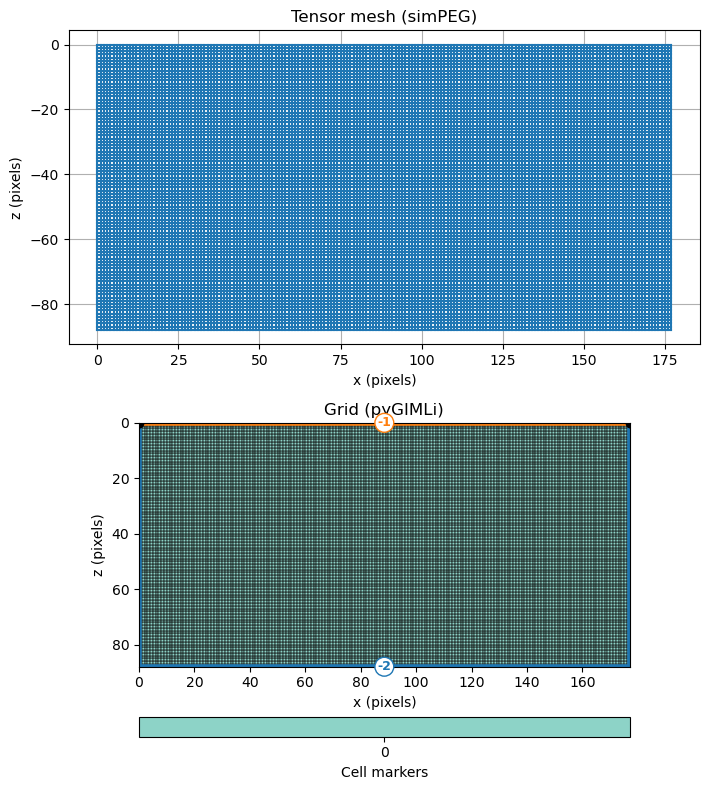

In [72]:
## simPEG
# Specify the length and the number of cells in the horizontal direction
hx = [(1, total_pixels_after_refinement)]
# Specify the length and the number of cells in the vertical direction
# hz = [(1, vertical_size)]
hz = [(1, vertical_size + air_layer_thickness)]
# Create the tensor mesh, origin is at the top left corner
mesh = TensorMesh((hx, hz), origin="0N")
# We want the origin to be at the surface which is below the air layer
mesh.origin = mesh.origin + np.r_[0., air_layer_thickness]

## pyGIMLi
# Create the x coordinates
x_arr: np.ndarray[np.float64] = np.linspace(0., total_pixels_after_refinement, total_pixels_after_refinement + 1, dtype=np.float64)
# Create the z coordinates
z_arr: np.ndarray[np.float64] = np.linspace(-vertical_size, 0, vertical_size + 1, dtype=np.float64)
# Create the mesh
world: pg.core.Mesh = pg.createGrid(x=x_arr, y=z_arr, worldBoundaryMarker=True)

# Plot the mesh
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
mesh.plot_grid(ax=axes[0])
axes[0].set_title("Tensor mesh (simPEG)")
axes[0].set_xlabel("x (pixels)")
axes[0].set_ylabel("z (pixels)")
axes[0].set_aspect("equal")

axes[1].set_aspect("equal")
pg.show(world, showMesh=True, markers=True, ax=axes[1])
axes[1].set_title("Grid (pyGIMLi)")
axes[1].set_xlabel("x (pixels)")
axes[1].set_ylabel("z (pixels)")
plt.tight_layout()
plt.show()

With SimPEG, we need to construct ourselves the electrode schemes. Here are two functions to build a Schlumberger array and a Wenner array given a number of electrodes and their locations.

In [73]:
def schlumberger_array(nbr_electrodes: int,
                       electrode_locations: np.ndarray[np.float64],
                       data_type: str
                       ) -> list[dc.sources.Dipole]:
    source_list = []
    for a in range(1, nbr_electrodes // 2):
        locations_a = electrode_locations[:(-2 * a) - 1]
        locations_b = electrode_locations[(2 * a) + 1:]
        locations_m = electrode_locations[a:-a - 1]
        locations_n = electrode_locations[a + 1:-a]
        receivers_list_a = [
            dc.receivers.Dipole(locations_m=loc_m, locations_n=loc_n, data_type=data_type)
            for loc_m, loc_n in zip(locations_m, locations_n)
        ]
        source_list_a = [
            dc.sources.Dipole(
                receiver_list_a, location_a=loc_a, location_b=loc_b
            )
            for receiver_list_a, loc_a, loc_b in zip(receivers_list_a, locations_a, locations_b)
        ]
        source_list += source_list_a
    return source_list

def wenner_array(nbr_electrodes: int,
                 electrode_locations: np.ndarray[np.float64],
                 data_type: str
                 ) -> list[dc.sources.Dipole]:
    source_list = []
    for a in range(1, (nbr_electrodes + 3) // 3 + 1):
        locations_a = electrode_locations[:-3 * a:]
        locations_b = electrode_locations[3 * a:]
        locations_m = electrode_locations[a:-2 * a:]
        locations_n = electrode_locations[2 * a:-a]
        receivers_list_a = [
            dc.receivers.Dipole(locations_m=loc_m, locations_n=loc_n, data_type=data_type)
            for loc_m, loc_n in zip(locations_m, locations_n)
        ]
        source_list_a = [
            dc.sources.Dipole(
                receiver_list_a, location_a=loc_a, location_b=loc_b
            )
            for receiver_list_a, loc_a, loc_b in zip(receivers_list_a, locations_a, locations_b)
        ]

        source_list += source_list_a
    return source_list

We have create the positions of the electrodes and we can then create a survey object.

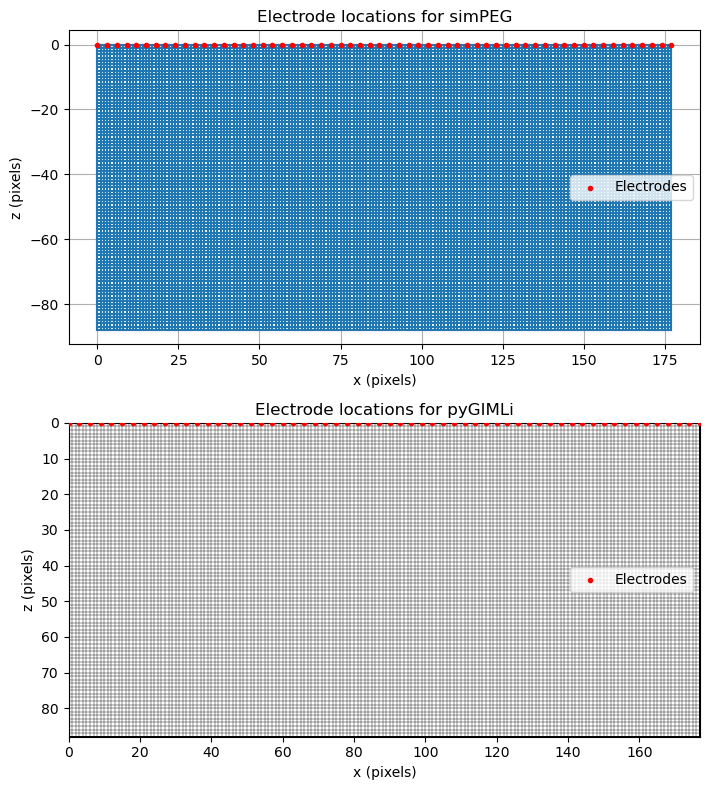

In [74]:
## simPEG
# Define the measurement data type
data_type = "apparent_resistivity"

# Define electrode locations
electrode_locations_x_simPEG = np.linspace(0, total_pixels_after_refinement, num_electrodes)
electrode_locations_z_simPEG = np.zeros_like(electrode_locations_x_simPEG)
electrode_locations_simPEG = np.c_[electrode_locations_x_simPEG, electrode_locations_z_simPEG]

array = schlumberger_array
# array = wenner_array
source_list = array(num_electrodes, electrode_locations_simPEG, data_type)

# Define survey
survey = dc.Survey(source_list)


## pyGIMLi
# Define scheme
scheme_name: str = "wa" if array == wenner_array else "slm"

# Define electrode locations
elec_array: np.float64 = np.linspace(0., total_pixels_after_refinement, num_electrodes, dtype=np.float64)  # np.float64 to be compatible with C++ double
# Create the data container
scheme: pg.DataContainerERT = ert.createData(elecs=elec_array, schemeName=scheme_name)
electrode_locations_pyGIMLi: np.ndarray[np.float64] = np.array([scheme.sensorPosition(i) for i in range(scheme.sensorCount())])


# Plot the electrode locations for both simPEG and pyGIMLi
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
mesh.plot_grid(ax=axes[0])
axes[0].scatter(electrode_locations_x_simPEG, electrode_locations_z_simPEG, marker='.', color='red', label='Electrodes', zorder=10)
axes[0].set_xlabel("x (pixels)")
axes[0].set_ylabel("z (pixels)")
axes[0].set_title("Electrode locations for simPEG")
axes[0].set_aspect("equal")
axes[0].legend(loc="center right")

pg.show(world, ax=axes[1], showMesh=True)
axes[1].scatter(electrode_locations_pyGIMLi[:, 0], electrode_locations_pyGIMLi[:, 1], marker='.', color='red', label='Electrodes', zorder=10)
axes[1].set_xlabel("x (pixels)")
axes[1].set_ylabel("z (pixels)")
axes[1].set_title(f"Electrode locations for pyGIMLi")
axes[1].set_aspect("equal")
axes[1].legend(loc="center right")

plt.tight_layout()
plt.show()

In [75]:
def get_pseudo_locations_pyGIMLi(scheme):
    pseudo_locs = []
    
    for i in range(scheme.size()):
        # Get electrode positions
        a = scheme.sensorPosition(scheme('a')[i])
        b = scheme.sensorPosition(scheme('b')[i])
        m = scheme.sensorPosition(scheme('m')[i])
        n = scheme.sensorPosition(scheme('n')[i])
        
        # Compute the pseudo-location
        x_pseudo = (a.x() + b.x() + m.x() + n.x()) / 4
        z_pseudo = abs(b.x() - a.x()) / 2
        
        pseudo_locs.append([x_pseudo, -z_pseudo])
    
    return np.array(pseudo_locs)

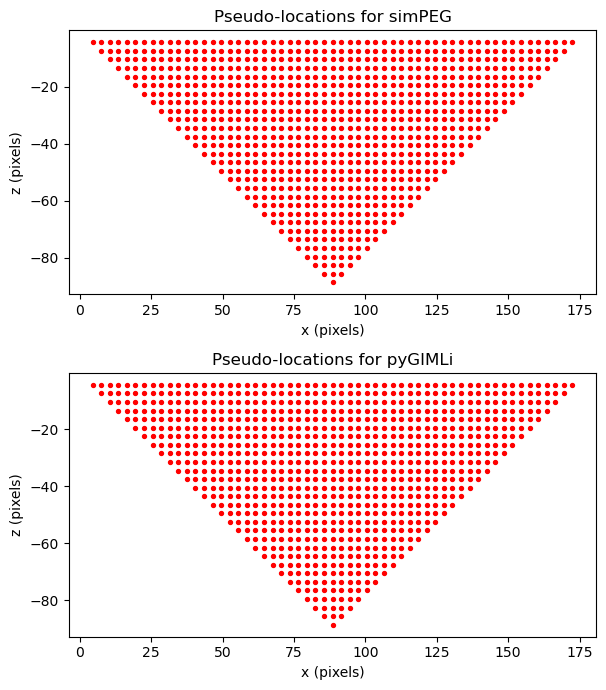

In [76]:
## simPEG
# Extract the pseudo-locations
pseudo_locations_simPEG = pseudo_locations(survey)


## pyGIMLi
# Extract the pseudo-locations
pseudo_locations_pyGIMLi = get_pseudo_locations_pyGIMLi(scheme)


# Plot the pseudo-locations
fig, axes = plt.subplots(2, 1, figsize=(10, 7))
axes[0].scatter(pseudo_locations_simPEG[:, 0], pseudo_locations_simPEG[:, -1], 8, "r")
axes[0].set_xlabel("x (pixels)")
axes[0].set_ylabel("z (pixels)")
axes[0].set_title("Pseudo-locations for simPEG")
axes[0].set_aspect("equal")

axes[1].scatter(pseudo_locations_pyGIMLi[:, 0], pseudo_locations_pyGIMLi[:, 1], 8, "r")
axes[1].set_xlabel("x (pixels)")
axes[1].set_ylabel("z (pixels)")
axes[1].set_title("Pseudo-locations for pyGIMLi")
axes[1].set_aspect("equal")
plt.tight_layout()
plt.show()

Create a topography for simPEG

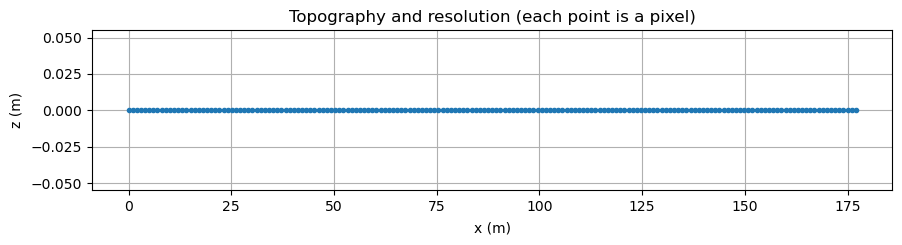

In [77]:
# Create x coordinates
x_topo = np.linspace(0, total_pixels_after_refinement, total_pixels_after_refinement)
# We want a flat topography
z_topo = np.zeros_like(x_topo)
# Create the 2D topography
topo_2d = np.c_[x_topo, z_topo]

# Plot 2D topography
fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x_topo, z_topo, marker=".")
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("z (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography and resolution (each point is a pixel)")
plt.show(fig)

Now we need to inactivate air cells as they should not participate in the forward modelling.

In [78]:
## simPEG
# We activate all cells below the surface
active_cells = active_from_xyz(mesh, topo_2d)
# Compute the number of active cells
n_active = np.sum(active_cells)

To map resistivity model to mesh, we need to use IdentityMap.

In [79]:
# Inactive cells will be filled with air_resistivity
air_resistivity: float = 1e8
# Multiplying the resistivity map with the resistivity model (without air layer) will associate the resistivity value to the active cells
# resistivity_map = maps.InjectActiveCells(mesh, active_cells, air_resistivity)
resistivity_map = maps.IdentityMap(mesh, nP=mesh.n_cells)

Plot the mesh, the resistivity model and the electrodes.

Time to create plotting map: 0.0023970980000740383 s
Time to create plotting map: 0.00012349999997240957 s
Time to create plotting map: 9.069999941857532e-05 s


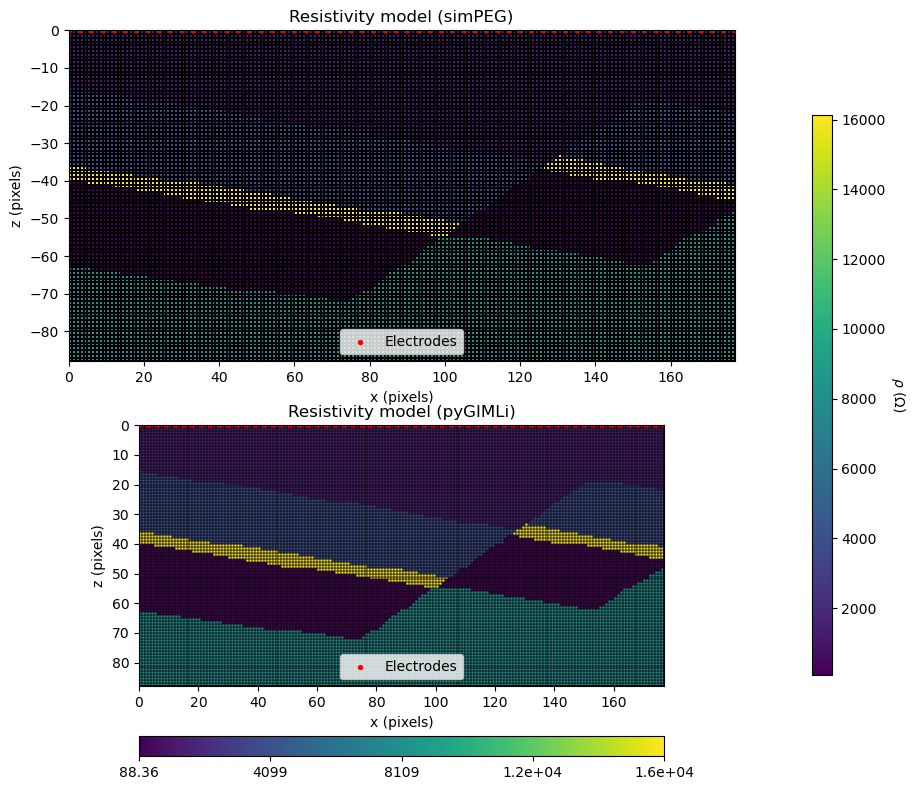

In [80]:
# For plotting, we won't plot the air layer
start = perf_counter()
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)
stop = perf_counter()
print(f"Time to create plotting map: {stop - start} s")
start = perf_counter()
plotting_map = maps.IdentityMap(mesh, mesh.n_cells)
stop = perf_counter()
print(f"Time to create plotting map: {stop - start} s")
start = perf_counter()
plotting_map = maps.IdentityMap(mesh)
stop = perf_counter()
print(f"Time to create plotting map: {stop - start} s")

# Plot the resistivity model on the mesh
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

norm = LogNorm(vmin=np.min(resistivity_model_flat), vmax=np.max(resistivity_model_flat))
mesh_plot = mesh.plot_image(plotting_map * resistivity_model_flat, ax=axes[0], grid=True)
for grid_line in mesh_plot:
    grid_line.set_linewidth(0.1)  # Change the grid line width
axes[0].set_title("Resistivity model (simPEG)")
axes[0].scatter(electrode_locations_x_simPEG, electrode_locations_z_simPEG, 8, "r", label="Electrodes")
axes[0].set_xlabel("x (pixels)")
axes[0].set_ylabel("z (pixels)")
axes[0].set_aspect("equal")
axes[0].legend(loc="lower center")

pg.show(world, data=resistivity_model_flat, showMesh=True, ax=axes[1])
axes[1].scatter(electrode_locations_pyGIMLi[:, 0], electrode_locations_pyGIMLi[:, 1], 8, "r", label="Electrodes")
axes[1].set_title("Resistivity model (pyGIMLi)")
axes[1].set_xlabel("x (pixels)")
axes[1].set_ylabel("z (pixels)")
axes[1].set_aspect("equal")
axes[1].legend(loc="lower center")

# Add a shared colorbar between both subplots
cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.7])  # Position for the colorbar
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, norm=norm)
cbar.set_label(r"$\rho$ ($\Omega$)", rotation=270, labelpad=15)

plt.show()

We ensure that electrodes are on the mesh, at the surface.

In [206]:
survey.drape_electrodes_on_topography(mesh, active_cells, option="top", topography=topo_2d)

We can now instantiate the simulation class.

In [207]:
_ = survey.set_geometric_factor()
resistivity_simulation = dc.simulation_2d.Simulation2DNodal(mesh, survey=survey, rhoMap=resistivity_map)

And this is the forward step:

In [208]:
## simPEG
start_time_simPEG = perf_counter()
forward_model_simPEG = resistivity_simulation.dpred(resistivity_model_flat)
stop_time_simPEG = perf_counter()

## pyGIMLi
start_time_pyGIMLi = perf_counter()
forward_model_pyGIMLi = ert.simulate(world, res=resistivity_model_flat, scheme=scheme, verbose=True)
stop_time_pyGIMLi = perf_counter()

/root/miniconda3/envs/venv_explor/lib/python3.11/site-packages/simpeg/simulation.py:197: DefaultSolverWarning: Using the default solver: SolverLU. 

If you would like to suppress this notification, add 
warnings.filterwarnings('ignore', simpeg.utils.solver_utils.DefaultSolverWarning)
 to your script.
  return get_default_solver(warn=True)
/root/miniconda3/envs/venv_explor/lib/python3.11/site-packages/pymatsolver/wrappers.py:79: UnusedArgumentWarning: Unused keyword argument "is_symmetric" for splu.
  self.kwargs = kwargs
/root/miniconda3/envs/venv_explor/lib/python3.11/site-packages/pymatsolver/wrappers.py:79: UnusedArgumentWarning: Unused keyword argument "is_positive_definite" for splu.
  self.kwargs = kwargs
/root/miniconda3/envs/venv_explor/lib/python3.11/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)


ModellingBase::setMesh() copying new mesh ... Found datafile: 30 electrodes
Found: 30 free-electrodes
rMin = 2, rMax = 232
NGauLeg + NGauLag for inverse Fouriertransformation: 12 + 4
Found non-Neumann domain
0.152513 s
FOP updating mesh dependencies ... 2e-06 s
Calculating response for model: min = 7.02718 max = 4383.81
Allocating memory for primary potential...... 0.0010186

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 3.92598s
Response: min = 7.07249 max = 19.2056 mean = 11.1556
Reciprocity rms(modelReciprocity) 2.78609%, max: 0.663261%


In [209]:
print(f"Forward time simPEG: {stop_time_simPEG - start_time_simPEG}")
print(f"Forward time pyGIMLi: {stop_time_pyGIMLi - start_time_pyGIMLi}")

Forward time simPEG: 3.7323901819981984
Forward time pyGIMLi: 4.244796873001178


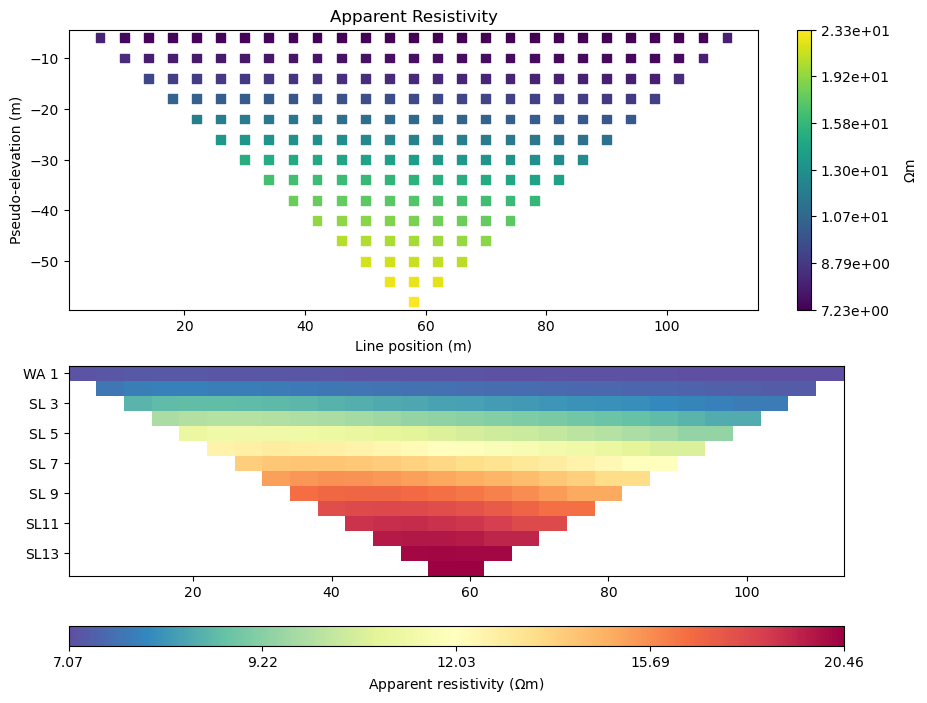

In [210]:
# Plot apparent resistivity pseudo-section
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

plot_pseudosection(
    survey,
    dobs=forward_model_simPEG,
    ax=axes[0],
    scale="log",
    cbar_label="$\Omega$m",
    plot_type="scatter",
    scatter_opts={"marker": "s"},
)
axes[0].set_title("Apparent Resistivity")

ert.showERTData(forward_model_pyGIMLi, ax=axes[1])

plt.show()

In [211]:
def process_pseudo_section_wenner_array(rhoa: list[float],
                                        nbr_electrodes: int
                                        ) -> np.ndarray[np.float64]:
    num_rows: int = (nbr_electrodes - 1) // 3
    num_cols: int = nbr_electrodes - 3

    even_num_cols: bool = (num_cols % 2 == 0)
    if even_num_cols:
        # We want non even number of columns to be able to center the
        # triangle.
        num_cols += 1

    offset: int = (nbr_electrodes - 1) % 2

    pseudo_section: np.ndarray[np.float64] = np.empty(
        (num_rows, num_cols), dtype=np.float64)
    pseudo_section.fill(np.nan)
    value_index: int = 0

    for i in range(num_rows):
        # Determine if the current row is considered "even" based on num_cols
        # parity
        is_even_row = (i % 2 == 0) if even_num_cols else (i % 2 == 1)

        col_start, col_end = compute_active_columns(
            i, is_even_row, num_cols, offset)

        for j in range(col_start, col_end):
            # For even rows, use a special average at the center column
            if is_even_row and j == (num_cols - 1) // 2:
                pseudo_section[i, j] = (
                    rhoa[value_index - 1] + rhoa[value_index]) / 2
            else:
                pseudo_section[i, j] = rhoa[value_index]
                value_index += 1
    return pseudo_section

def process_pseudo_section_schlumberger_array(rhoa: list[float],
                                              nbr_electrodes: int
                                              ) -> np.ndarray[np.float64]:
    num_cols: int = nbr_electrodes - 3
    num_lines: int = nbr_electrodes // 2 - 1

    pseudo_section: np.ndarray[np.float64] = np.empty(
        (num_lines, num_cols), dtype=np.float64)
    pseudo_section.fill(np.nan)

    value_index: int = 0
    for i in range(num_lines):
        start_col: int = i
        end_col: int = num_cols - i
        num_values_this_row: int = end_col - start_col
        pseudo_section[i, start_col:end_col] = rhoa[value_index: value_index +
                                                    num_values_this_row]
        value_index += num_values_this_row

    return pseudo_section

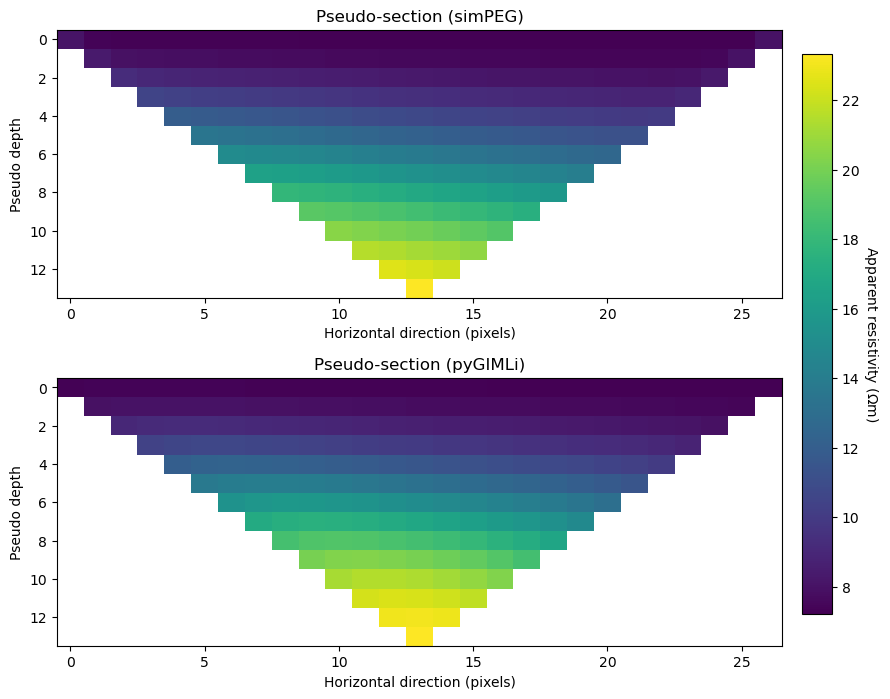

In [212]:
if array == wenner_array:
    process_pseudo_section = process_pseudo_section_wenner_array
else:
    process_pseudo_section = process_pseudo_section_schlumberger_array

pseudo_section_simPEG = process_pseudo_section(forward_model_simPEG, num_electrodes)
pseudo_section_pyGIMLi = process_pseudo_section(forward_model_pyGIMLi['rhoa'], num_electrodes)

vmin = min(np.min(pseudo_section_simPEG), np.min(pseudo_section_pyGIMLi))
vmax = max(np.max(pseudo_section_simPEG), np.max(pseudo_section_pyGIMLi))
norm = LogNorm(vmin=vmin, vmax=vmax)

# Plot the pseudo-sections
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
im1 = axes[0].imshow(pseudo_section_simPEG, cmap="viridis")
axes[0].set_title("Pseudo-section (simPEG)")
axes[0].set_ylabel("Pseudo depth")
axes[0].set_xlabel("Horizontal direction (pixels)")
axes[0].set_aspect("auto")

axes[1].imshow(pseudo_section_pyGIMLi, cmap="viridis")
axes[1].set_title("Pseudo-section (pyGIMLi)")
axes[1].set_ylabel("Pseudo depth")
axes[1].set_xlabel("Horizontal direction (pixels)")
axes[1].set_aspect("auto")

# Adjust layout to prevent overlap
plt.subplots_adjust(hspace=0.3, right=0.85)

# Add a joint colorbar for both subplots
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # Adjusted position for the colorbar
cbar = fig.colorbar(im1, cax=cbar_ax)  # Use im1 to create a joint colorbar
cbar.set_label("Apparent resistivity ($\Omega$m)", rotation=270, labelpad=15)

plt.show()

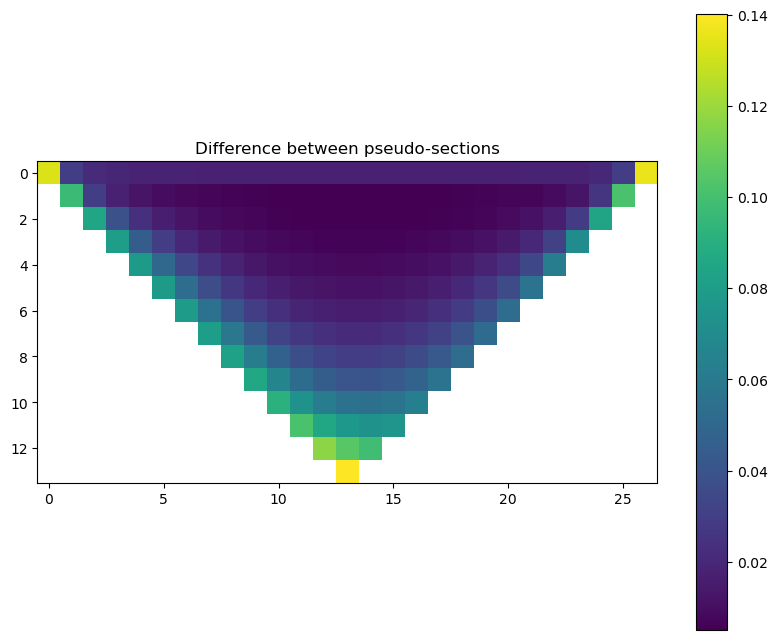

: 

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(np.abs(pseudo_section_simPEG - pseudo_section_pyGIMLi) / pseudo_section_pyGIMLi, cmap="viridis")
plt.colorbar()
plt.title("Difference between pseudo-sections")
plt.show()